## Initialisation

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

In [2]:
load_dotenv()

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
   client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET"),
    redirect_uri=os.getenv("SPOTIPY_REDIRECT_URI")
))

# Partie 1

In [3]:
def get_playlist_ids(playlist_name):

    """ Retourne l'id de la playlist à partir de son nom """

    results = sp.search(q=playlist_name, type='playlist', limit=10)
    for playlist in results['playlists']['items']:
        if playlist['name'].strip() == playlist_name:
            print("playlist utilisée: " + playlist['name'])
            return playlist['id']
            
            
def get_tracks_from_playlist(playlist_id):

    """ Retourne les tracks de la playlist à partir de son ID """

    tracks = sp.playlist(playlist_id)['tracks']['items']
    return tracks

def get_artist_infos(tracks):

    """ Retourne les informations des artistes à partir de tracks """

    unique_artist_id = list({
        artist['id']
        for item in tracks
        for artist in item['track']['artists']
    })
    
    result = []
    for i in range(0, len(unique_artist_id), 50):
        batch_artist_id = unique_artist_id[i:i + 50]
        artist_result = sp.artists(batch_artist_id)
        result.extend(artist_result['artists'])

    return result

In [10]:
top_hits = []
artist_infos = []

# On extrait les tracks présents dans les playlists réalisées par Spotify “Top Hits of YYYY” sur les hits des 5 dernières années (2020 à 2024)
for year in range(2020, 2025):
    tracks = get_tracks_from_playlist(get_playlist_ids(f'Top Hits of {year}'))
    for track in tracks:
        track['playlist_year'] = year
    top_hits.extend(tracks)
    artist_infos.extend(get_artist_infos(tracks))
    
df_artist_infos = pd.DataFrame([
        {
            'artist_id': artist['id'],
            'artist_name': artist['name'],
            'artist_followers': artist['followers']['total'],
            'artist_popularity': artist['popularity'],
            'artist_genres': artist['genres']
        }
        for artist in artist_infos
    ])

df_track = pd.DataFrame([
    {
        'track_id': item['track']['id'],
        'track_name': item['track']['name'],
        'track_duration_ms': item['track']['duration_ms'],
        'track_popularity': item['track']['popularity'],
        'album_name': item['track']['album']['name'],
        'album_release_date': item['track']['album']['release_date'],
        'artist_id': artist['id'],
        'playlist_year': item['playlist_year']
        
    }
    for item in top_hits
    for artist in item['track']['artists']
])

playlist utilisée: Top Hits of 2020
playlist utilisée: Top Hits of 2021
playlist utilisée: Top Hits of 2022
playlist utilisée: Top Hits of 2023
playlist utilisée: Top Hits of 2024


## a)

In [12]:
# Informations liées aux artistes
df_artist_infos = df_artist_infos.drop_duplicates(subset='artist_id').reset_index(drop=True)
df_artist_infos.head(10)

,artist_id,artist_name,artist_followers,artist_popularity,artist_genres
0,3TVXtAsR1Inumwj472S9r4,Drake,99535105,98,[rap]
1,26VFTg2z8YR0cCuwLzESi2,Halsey,22179332,84,[]
2,1r4hJ1h58CWwUQe3MxPuau,Maluma,37307671,88,"[reggaeton, latin, urbano latino]"
3,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,113690769,95,[]
4,35WVTyRnKAoaGExqgktVyb,Hotel Ugly,990824,74,[]
5,7rkW85dBwwrJtlHRDkJDAC,NAV,3550499,74,[melodic rap]
6,7uMh23xWiuR7zsNkuNcm2G,MNEK,304926,69,[]
7,0C8ZW7ezQVs4URX5aX7Kqx,Selena Gomez,52706708,86,[]
8,1anyVhU62p31KFi8MEzkbf,Chance the Rapper,6027594,76,[]
9,7dGJo4pcD2V6oG8kP0tJRR,Eminem,101603318,92,"[rap, hip hop]"


## b)

In [13]:
# Informations liées aux tracks
df_unique_tracks = df_track.drop(columns=['artist_id']).drop_duplicates(subset=['track_id','playlist_year'])
df_unique_tracks.head(10)

,track_id,track_name,track_duration_ms,track_popularity,album_name,album_release_date,playlist_year
0,0sf12qNH5qcw8qpgymFOqD,Blinding Lights,201573,26,Blinding Lights,2019-11-29,2020
1,0nbXyq5TXYPCO7pr3N8S4I,The Box,196652,85,Please Excuse Me for Being Antisocial,2019-12-06,2020
2,696DnlkuDOXcMAnKlTgXXK,ROXANNE,163636,77,ROXANNE,2019-10-10,2020
3,7igeByaBM0MgGsgXtNxDJ7,positions,172324,2,positions,2020-10-23,2020
4,3Dv1eDb0MEgF93GpLXlucZ,Say So,237893,79,Hot Pink,2019-11-07,2020
5,6UelLqGlWMcVH1E5c4H7lY,Watermelon Sugar,174000,87,Fine Line,2019-12-13,2020
6,6WrI0LAC5M1Rw2MnX2ZvEg,Don't Start Now,183290,76,Don't Start Now,2019-10-31,2020
7,7eJMfftS33KTjuF7lTsMCx,death bed (coffee for your head),173333,84,death bed (coffee for your head),2020-02-08,2020
9,4LEK9rD7TWIG4FCL1s27XC,cardigan,239560,51,folklore,2020-07-24,2020
10,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,245425,86,everything i wanted,2019-11-13,2020


# Partie 2

## a)

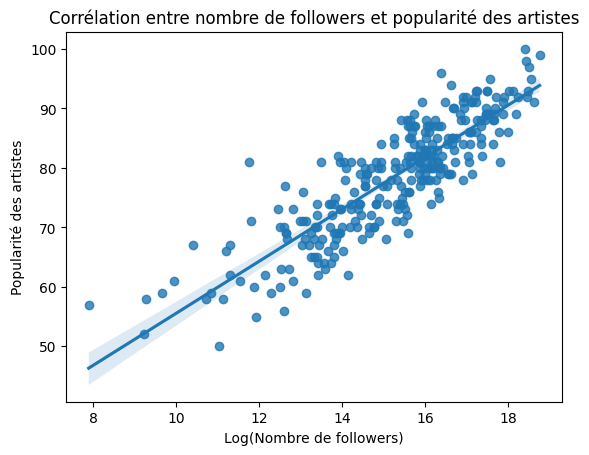

In [14]:
# On ajoute une colonne log(artist_followers) pour améliorer la visibilité (car trop grosse dispersion du nombre de followers)
df_artist_infos['log_followers'] = np.log(df_artist_infos['artist_followers'])

# Scatter plot + droite de régression
sns.regplot(data=df_artist_infos, x='log_followers', y='artist_popularity')
plt.title("Corrélation entre nombre de followers et popularité des artistes")
plt.xlabel("Log(Nombre de followers)")
plt.ylabel("Popularité des artistes")
plt.show()

On observe une forte corrélation positive (faible dispertion des points autour de la droite) 
entre le nombre de followers et la popularité des artistes 
avec une droite de regression dont la pente est significativement croissante.

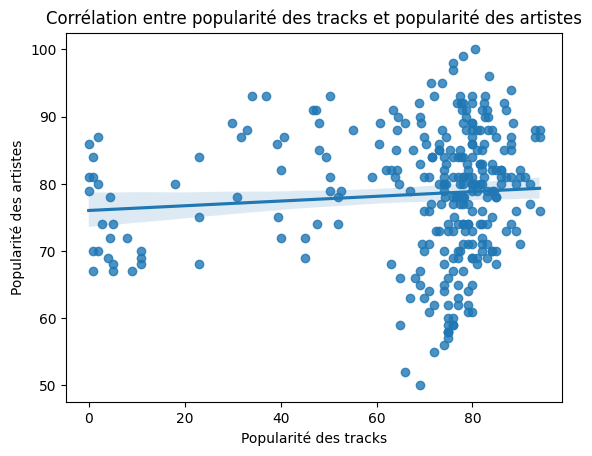

In [15]:
# On construit un dataframe pour calculer la popularité moyenne des tracks par artiste
df_merged = pd.merge(df_track, df_artist_infos, on='artist_id', how='inner')
df_merged['avg_track_popularity_per_artist'] = df_merged.groupby('artist_id')['track_popularity'].transform('mean').round(2)
df_artist_summary = df_merged[['artist_id','artist_name', 'artist_popularity', 'avg_track_popularity_per_artist']].drop_duplicates(subset='artist_id')

# Scatter + droite de régression
sns.regplot(data=df_artist_summary, x='avg_track_popularity_per_artist', y='artist_popularity')
plt.title("Corrélation entre popularité des tracks et popularité des artistes")
plt.xlabel("Popularité des tracks")
plt.ylabel("Popularité des artistes")
plt.show()

On observe une corrélation quasi inexistante (forte dispertion des points autour de la droite) 
entre la popularité moyenne des tracks et la popularité des artistes 
avec une droite de regression dont la pente est proche de zéro. 
Il n'existe pas de relation linéaire entre les deux variables.

## b)

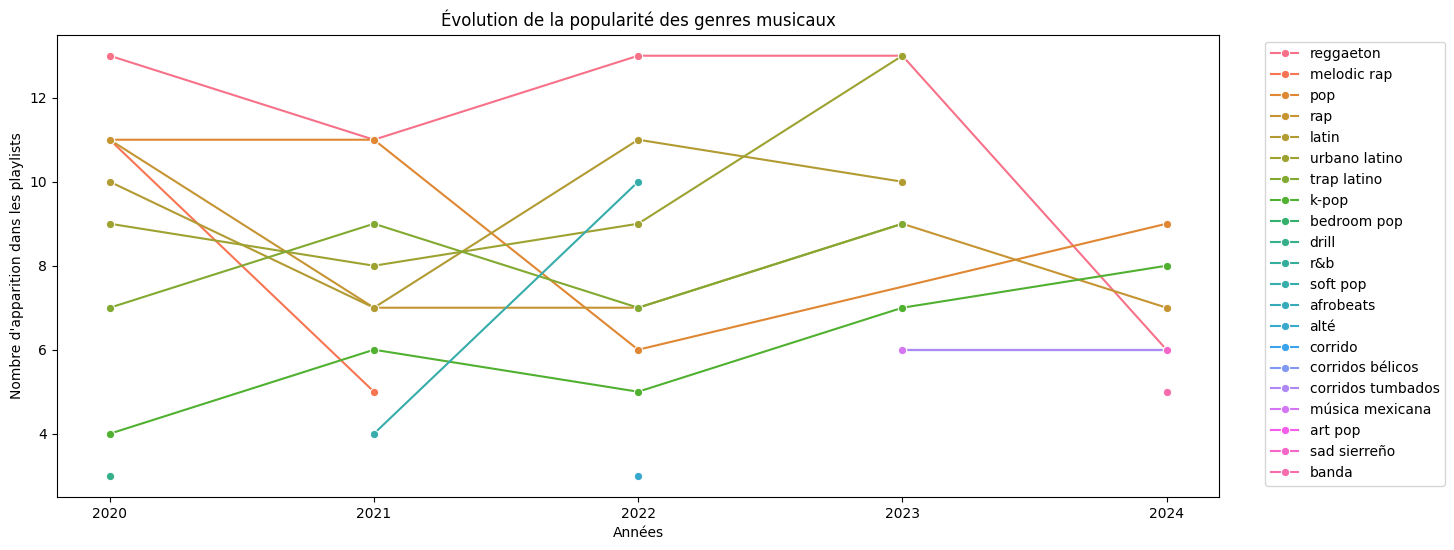

In [16]:
# On identifie les 10 genres musicaux les plus représentés dans chaque playlist en comptant leur fréquence d'apparition.
df_genres = df_merged.explode('artist_genres')
genre_year_pop = df_genres.groupby(['playlist_year', 'artist_genres']).size().reset_index(name='count')

top_count_genres_per_year = (
    genre_year_pop
    .sort_values(['playlist_year', 'count'], ascending=[True, False])
    .groupby('playlist_year')
    .head(10)
)

plt.figure(figsize=(15,6))
sns.lineplot(data=top_count_genres_per_year, x='playlist_year', y='count', hue='artist_genres', marker='o')
plt.legend(bbox_to_anchor=(1.2, 1), ncol=1)
plt.xticks(sorted(top_count_genres_per_year['playlist_year'].unique()))
plt.title("Évolution de la popularité des genres musicaux")
plt.ylabel("Nombre d'apparition dans les playlists")
plt.xlabel("Années")
plt.show()

En prenant en compte les 10 genres musicaux les plus présents dans chaque playlist (pour améliorer la visibilité),
on observe une évolution des genres les plus écoutés entre 2020 et 2024. 
Par exemple, le reggaeton, qui était le genre le plus présent de 2020 à 2023, passe à la 4ᵉ position en 2024, tandis que la pop et la K-pop 
regagnent en popularité depuis 2022.

# Partie 3

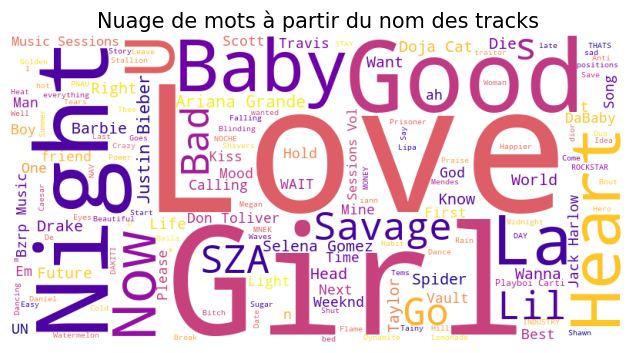

In [17]:
# Création d'un nuage de mots à partir du nom des tracks
text = ' '.join(df_unique_tracks['track_name'].dropna().astype(str))
stopwords = set(STOPWORDS)
stopwords.update(["feat", "ft", "remix", "version", "edit", "original", "live", "the", "and", "mix", "pt", "part"])
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='plasma',stopwords=stopwords,max_words=150,).generate(text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Nuage de mots à partir du nom des tracks", fontsize=15)
plt.show()

En générant un nuage de mots à partir des 150 mots les plus fréquents dans les noms des tracks (après exclusion des stopwords), 
on remarque que les termes 'Love', 'Girl', 'Heart' et 'Baby' apparaissent le plus souvent. 
Cela suggère une prédominance de thématiques liées à la romance dans les titres de tracks.